In [15]:
# Importing the libraries
import pandas as pd
import numpy as np
from IPython.display import display

import matplotlib.pyplot as plt
import re
import string

import spacy
from flair.models import TextClassifier
from flair.data import Sentence

from collections import Counter
from wordcloud import WordCloud

import seaborn as sns
import plotly.express as px

sns.set(style="darkgrid")

# Load spaCy model
nlp = spacy.load("en_core_web_sm")
stop_words = nlp.Defaults.stop_words

In [16]:
# Reading data from csv file
dataset = pd.read_csv("twitterEndSars.csv")
dataset.head()

,Unnamed: 0,url,date,content,id,username,outlinks,outlinksss,tcooutlinks,tcooutlinksss
0,0,https://twitter.com/hurbhiaghelee/status/13852...,2021-04-22 18:28:26+00:00,This is the highest form of intimidation\nWhat...,1385299471123238912,hurbhiaghelee,['https://twitter.com/AmaiweLove/status/138519...,https://twitter.com/AmaiweLove/status/13851900...,['https://t.co/xxdTK0BmQB'],https://t.co/xxdTK0BmQB
1,1,https://twitter.com/AlukoJoseph5/status/138524...,2021-04-22 15:07:05+00:00,Why is it taking a life long time for @MBuhari...,1385248799770267650,AlukoJoseph5,[],NaN,[],NaN
2,2,https://twitter.com/omofuma_Elijah/status/1385...,2021-04-22 10:13:20+00:00,"Even Desmond Elliot is quite , ,,, what is tha...",1385174876428902400,omofuma_Elijah,['https://twitter.com/vhic_tore/status/1385141...,https://twitter.com/vhic_tore/status/138514152...,['https://t.co/RsVQ4N8LwM'],https://t.co/RsVQ4N8LwM
3,3,https://twitter.com/FelixOdohoedi/status/13851...,2021-04-22 09:48:04+00:00,When will CBN freeze the account of @DrIsaPant...,1385168517104869378,FelixOdohoedi,['https://twitter.com/Imudia_se2/status/138495...,https://twitter.com/Imudia_se2/status/13849543...,['https://t.co/r3vxrbkLdn'],https://t.co/r3vxrbkLdn
4,4,https://twitter.com/adekzee1/status/1385164392...,2021-04-22 09:31:40+00:00,@Obiejazzyup @YeleSowore @MBuhari @EndSars @mb...,1385164392447238145,adekzee1,[],NaN,[],NaN


In [17]:
# Selecting relevant columns
needed_columns = ['username', 'date', 'content']
dataset = dataset[needed_columns]
dataset.head()

,username,date,content
0,hurbhiaghelee,2021-04-22 18:28:26+00:00,This is the highest form of intimidation\nWhat...
1,AlukoJoseph5,2021-04-22 15:07:05+00:00,Why is it taking a life long time for @MBuhari...
2,omofuma_Elijah,2021-04-22 10:13:20+00:00,"Even Desmond Elliot is quite , ,,, what is tha..."
3,FelixOdohoedi,2021-04-22 09:48:04+00:00,When will CBN freeze the account of @DrIsaPant...
4,adekzee1,2021-04-22 09:31:40+00:00,@Obiejazzyup @YeleSowore @MBuhari @EndSars @mb...


In [18]:
# Pre-processing text colmns

def preprocess_texts(dataset):
    #removing urls
    def remove_url(text):
        return re.sub(r'http\S+', '', str(text))

    #removing punctuations
    def remove_punctuation(text):
        return text.translate(str.maketrans('', '', string.punctuation))

    #removing stopwords (is, they, them, to, the etc)
    def remove_stopwords(text):
        return ' '.join([word for word in text.split() if word not in stop_words])

    # Combine all preprocessing steps
    def preprocess(text):
        text = remove_url(text)
        text = text.lower()
        text = remove_punctuation(text)
        text = remove_stopwords(text)
        return text

    dataset['preprocess_content'] = dataset['content'].apply(preprocess)

    return dataset

dataset = preprocess_texts(dataset)
dataset.head()

,username,date,content,preprocess_content
0,hurbhiaghelee,2021-04-22 18:28:26+00:00,This is the highest form of intimidation\nWhat...,highest form intimidation offence commit answe...
1,AlukoJoseph5,2021-04-22 15:07:05+00:00,Why is it taking a life long time for @MBuhari...,taking life long time mbuhari sack drisapantam...
2,omofuma_Elijah,2021-04-22 10:13:20+00:00,"Even Desmond Elliot is quite , ,,, what is tha...",desmond elliot womans look like jellof rice wa...
3,FelixOdohoedi,2021-04-22 09:48:04+00:00,When will CBN freeze the account of @DrIsaPant...,cbn freeze account drisapantami cbn quick free...
4,adekzee1,2021-04-22 09:31:40+00:00,@Obiejazzyup @YeleSowore @MBuhari @EndSars @mb...,obiejazzyup yelesowore mbuhari endsars mbujari...


In [19]:
# remove emoticons, symbols or flags by their codes
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# applying remove_emoji function on tweets
dataset['preprocess_content']=dataset['preprocess_content'].apply(lambda x: remove_emoji(x))
dataset.head()

,username,date,content,preprocess_content
0,hurbhiaghelee,2021-04-22 18:28:26+00:00,This is the highest form of intimidation\nWhat...,highest form intimidation offence commit answe...
1,AlukoJoseph5,2021-04-22 15:07:05+00:00,Why is it taking a life long time for @MBuhari...,taking life long time mbuhari sack drisapantam...
2,omofuma_Elijah,2021-04-22 10:13:20+00:00,"Even Desmond Elliot is quite , ,,, what is tha...",desmond elliot womans look like jellof rice wa...
3,FelixOdohoedi,2021-04-22 09:48:04+00:00,When will CBN freeze the account of @DrIsaPant...,cbn freeze account drisapantami cbn quick free...
4,adekzee1,2021-04-22 09:31:40+00:00,@Obiejazzyup @YeleSowore @MBuhari @EndSars @mb...,obiejazzyup yelesowore mbuhari endsars mbujari...


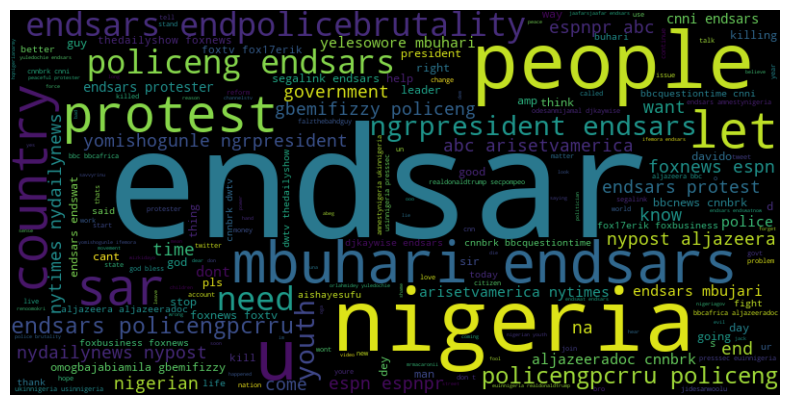

In [20]:
# Get the frequent words
peak_content = dataset['preprocess_content']

wordcloud = WordCloud(width=800, height=400).generate(' '.join(peak_content))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [21]:
# Tokenization
texts = dataset.preprocess_content

def tokenize(text):
    doc = nlp(text)
    return [token.text for token in doc]

texts_tokens = texts.apply(tokenize)
texts_tokens

0       [highest, form, intimidation, offence, commit,...
1       [taking, life, long, time, mbuhari, sack, dris...
2       [desmond, elliot, womans, look, like, jellof, ...
3       [cbn, freeze, account, drisapantami, cbn, quic...
4       [obiejazzyup, yelesowore, mbuhari, endsars, mb...
                              ...                        
9732    [yomishogunle, policengpcrru, policeng, apolog...
9733    [government, policeng, policengpcrru, pretend,...
9734    [endsars, issues, ending, sars, issue, reorien...
9735    [u, handsome, suspect, wear, new, shoe, suspec...
9736    [ca, nt, create, change, twitter, organise, ma...
Name: preprocess_content, Length: 9737, dtype: object

In [22]:
# prompt: remove token with less than letters

def remove_less_than_3_letters(tokens):
  return [token for token in tokens if len(token) > 2]

processed_text = [remove_less_than_3_letters(token) for token in texts_tokens]
processed_text

[['highest',
  'form',
  'intimidation',
  'offence',
  'commit',
  'answers',
  'ubacares',
  'ubafoundation',
  'ubacares',
  'tonyoelumelu',
  'npf',
  'davido',
  'viraltweets2020',
  'endsars',
  'humansnigeria'],
 ['taking',
  'life',
  'long',
  'time',
  'mbuhari',
  'sack',
  'drisapantami',
  'strong',
  'proof',
  'activities',
  'related',
  'terrorism',
  'cenbank',
  'endsars',
  'protesters',
  'account',
  'frozen',
  'excuse',
  'related',
  'terrorism',
  'drisapantami',
  'account',
  'active'],
 ['desmond',
  'elliot',
  'womans',
  'look',
  'like',
  'jellof',
  'rice',
  'way',
  'red',
  'oil',
  'men',
  'woman',
  'said',
  'stop',
  'social',
  'media',
  'endsars',
  'protest',
  'quiet',
  'abi'],
 ['cbn',
  'freeze',
  'account',
  'drisapantami',
  'cbn',
  'quick',
  'freeze',
  'account',
  'endsars',
  'pple',
  'including',
  'savvyrinu',
  'etc',
  'ground',
  'cryptocurrency',
  'finance',
  'terrorism',
  'financier',
  'advocate',
  'cbn',
  'wait

In [23]:
# Flatten the list of tokens and count the frequency of each token
all_tokens = [token for sublist in processed_text for token in sublist]
token_freq = Counter(all_tokens)

# Get the 50 most common words
common_tokens = token_freq.most_common(25)

# Convert to a DataFrame for easier plotting
common_tokens_df = pd.DataFrame(common_tokens, columns=['Word', 'Frequency'])

# Plotting with Plotly
fig = px.bar(common_tokens_df, x='Word', y='Frequency', title='25 Most Common Words')
fig.update_layout(xaxis_tickangle=-90)
fig.show()

In [25]:
# Lemmatization
def lemmatize(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

texts_lemmatized = texts.apply(lemmatize)
texts_lemmatized


In [ ]:
# Load Flair sentiment classifier
classifier = TextClassifier.load('sentiment')

# Sentiment analysis using Flair
def get_flair_sentiment(text):
    sentence = Sentence(text)
    classifier.predict(sentence)
    label = sentence.labels[0]
    return label.value.lower(), label.score

dataset['sentiment'] = texts_lemmatized.apply(lambda x: get_flair_sentiment(x)[0])
dataset['sentiment_score'] = texts_lemmatized.apply(lambda x: get_flair_sentiment(x)[1])
dataset.head()

2024-05-26 10:51:09,726 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-distilbert/sentiment-en-mix-distillbert_4.pt not found in cache, downloading to /tmp/tmpegkjzeq0


100%|██████████| 253M/253M [00:15<00:00, 17.2MB/s]

2024-05-26 10:51:25,773 copying /tmp/tmpegkjzeq0 to cache at /root/.flair/models/sentiment-en-mix-distillbert_4.pt


2024-05-26 10:51:26,441 removing temp file /tmp/tmpegkjzeq0


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

,username,date,content,preprocess_content,sentiment,sentiment_score
0,4928,2021-04-22,This is the highest form of intimidation\nWhat...,highest form intimidation offence commit answe...,negative,0.999112
1,382,2021-04-22,Why is it taking a life long time for @MBuhari...,taking life long time mbuhari sack drisapantam...,negative,0.999227
2,5768,2021-04-22,"Even Desmond Elliot is quite , ,,, what is tha...",desmond elliot womans look like jellof rice wa...,negative,0.995843
3,1441,2021-04-22,When will CBN freeze the account of @DrIsaPant...,cbn freeze account drisapantami cbn quick free...,negative,0.963661
4,4045,2021-04-22,@Obiejazzyup @YeleSowore @MBuhari @EndSars @mb...,obiejazzyup yelesowore mbuhari endsars mbujari...,positive,0.811645


In [ ]:
dataset.to_csv('/content/pre_processed_dataset.csv')